__Models and procedures__  
* Upload to AWS SQL (check)
* PCA for visualization (check)
* Log features (check)

In [247]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import pandas as pd
import numpy as np
import pickle
import re
import datetime as dt
import scipy.stats as stats
import random

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from operator import itemgetter, attrgetter, methodcaller

In [264]:
# Universal Modeling Tools
from sklearn.cross_validation import train_test_split 
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler

# Logistics Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

## Dataset 1: read in .txt data

In [249]:
%run '/Users/bellepeng/Desktop/Metis/Work/Projects/P3_Spam/data/col_names.py' # saved the column names in a sep .py to make it more readable

In [250]:
df = pd.read_table('/Users/bellepeng/Desktop/Metis/Work/Projects/P3_Spam/data/spambase_data.txt', sep=',', header=None)
df.columns=columns
print("% of Spam: ", df['spam'].sum()/df['spam'].count())
print("Total # of obs: ", df['spam'].count())
print("Dimension of df", df.shape)
df.head()

% of Spam:  0.394044772875
Total # of obs:  4601
Dimension of df (4601, 58)


,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


__Split into Test and Train and do EDA__

In [129]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1], df.iloc[:, -1], test_size = 0.2, random_state=99)

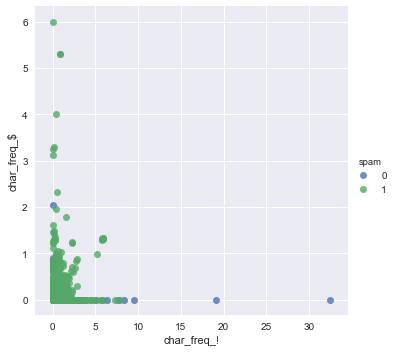

In [6]:
# Working
sns.lmplot(x='char_freq_!', y='char_freq_$', data=df, fit_reg=False, hue='spam', legend=True)

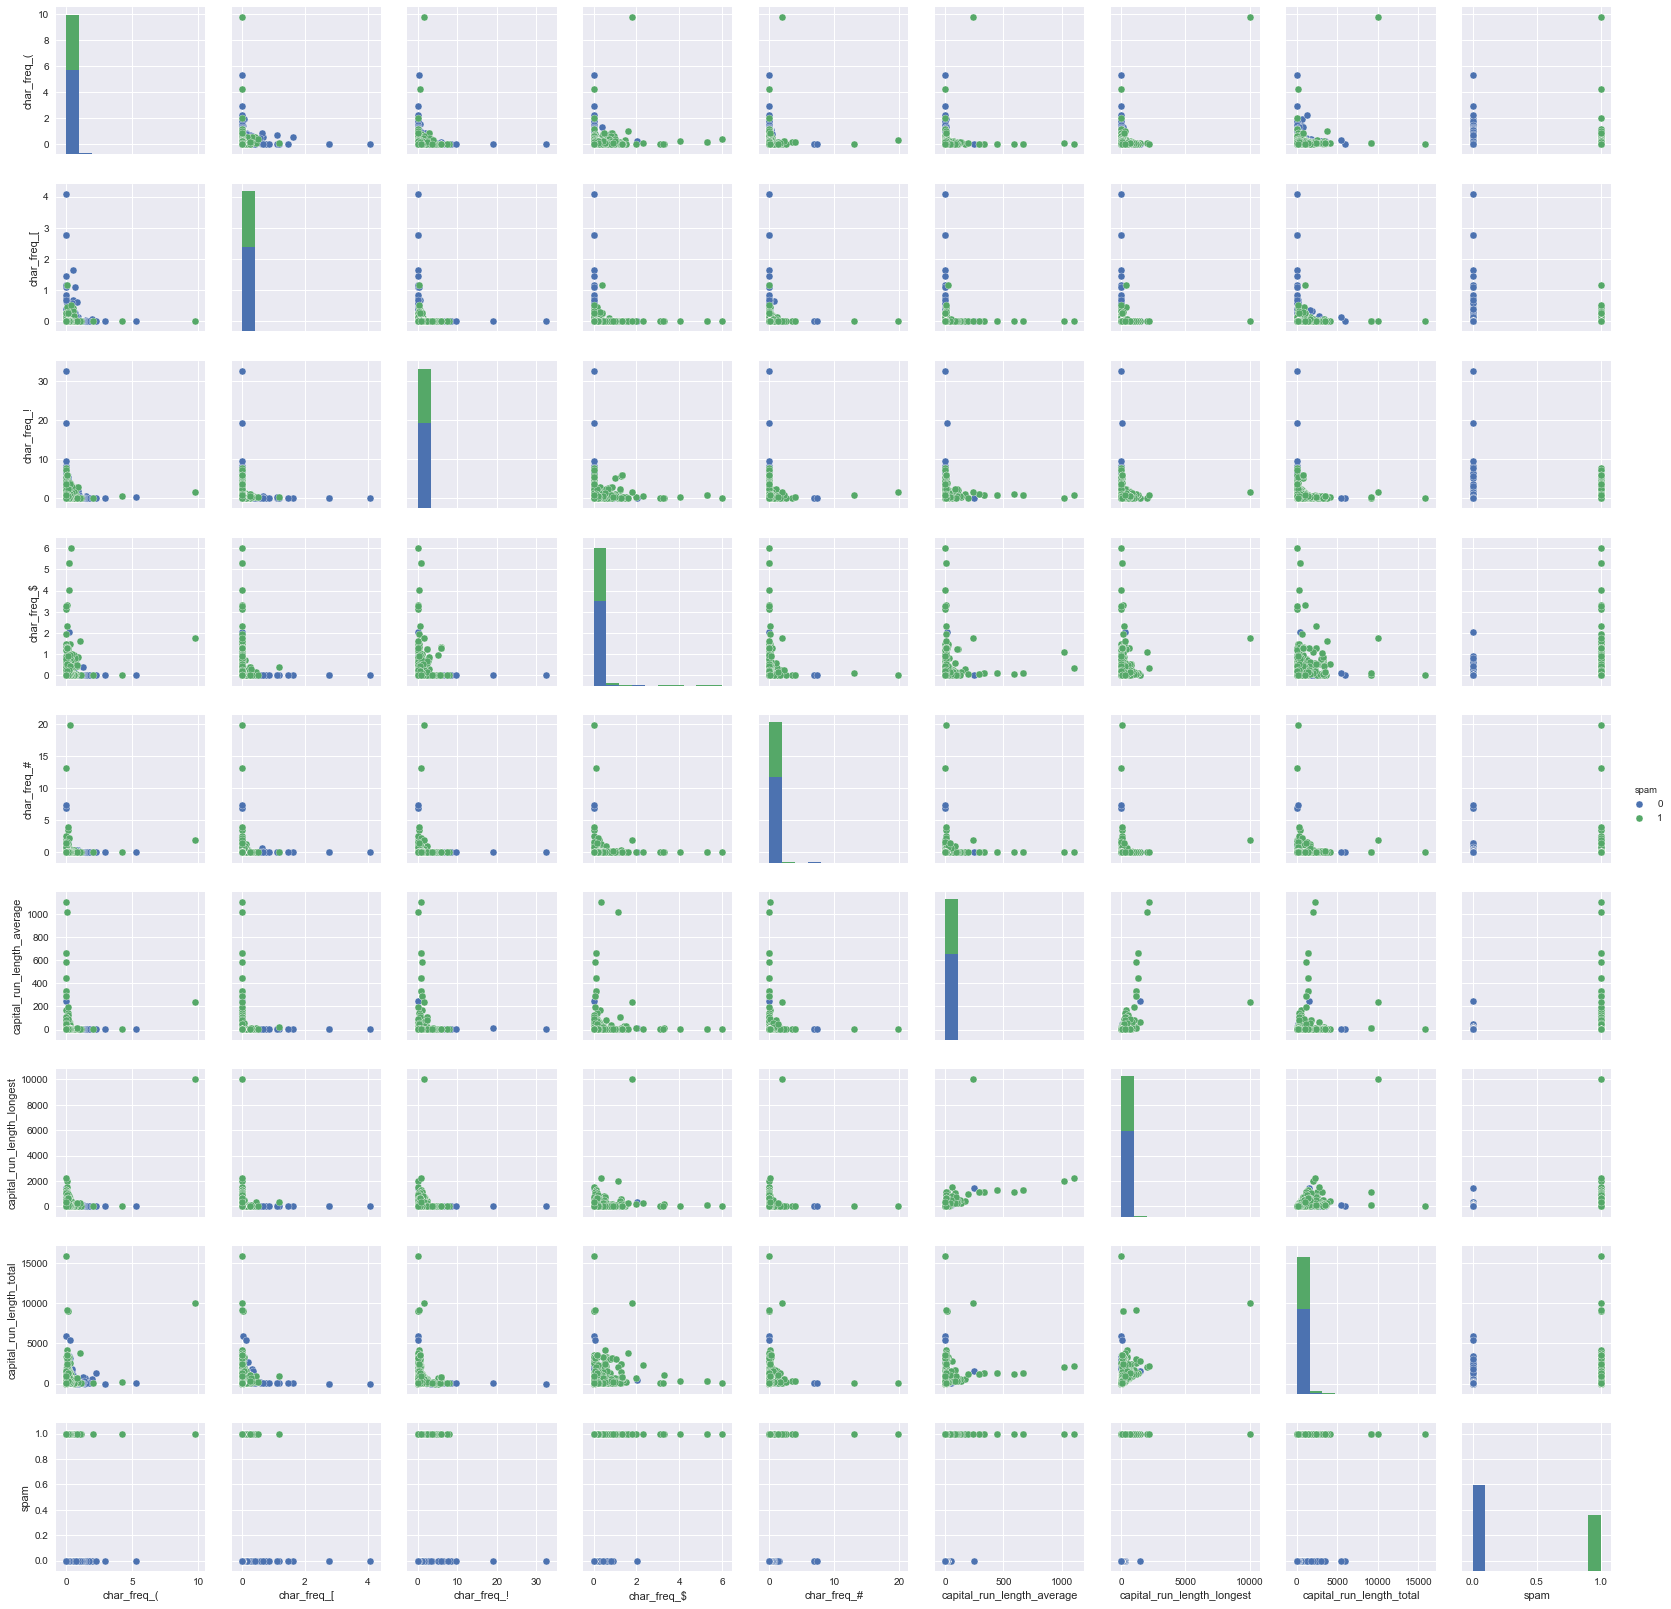

In [7]:
sub=df.loc[:, 'char_freq_(':'spam']
sns.pairplot(sub, hue='spam')

### Try Modeling

In [244]:
def Eval(y, pred):
    mat=confusion_matrix(y, pred)
    print("Accuracy: ",  f'{accuracy_score(y, pred):4.2%}')
    print("Precision: ", f'{precision_score(y, pred):4.2%}')
    print("Recall: ", f'{recall_score(y, pred):4.2%}')
    print("ROC AUC: ", f'{roc_auc_score(y, pred):4.2%}')
    print('False Negative Rate:', f'{ (mat[1][0]/(mat[0][0]+mat[1][0])):4.2%}')
    print('False Positve Rate:', f'{ (mat[0][1]/(mat[1][1]+mat[0][1])): 4.2%}')

    return pd.DataFrame(mat, columns=['Pred NOT Spam', 'Pred Spam'], 
                        index=['Actual NOT Spam', 'Actual Spam'])

In [130]:
lm1 = LogisticRegression(C=10)
lm1.fit(X_train, y_train)
prediction = lm1.predict(X_test)
Eval(y_test, prediction)

Accuracy:  92.51%
Precision:  91.64%
Recall:  89.95%
ROC AUC:  92.12%
False Negative Rate: 6.91%
False Positve Rate:  8.36%


,Pred NOT Spam,Pred Spam
Actual NOT Spam,512,31
Actual Spam,38,340


Accuracy:  92.51%  
Precision:  91.64%  
Recall:  89.95%  
ROC AUC:  92.12%  
False Negative Rate: 6.91%  
False Positve Rate:  8.36%

__Figure out which key words to look for in my other email dataset__

In [11]:
keywords=[]
def find_keywords(key):
    pos=key.find('freq_')+5
    return keywords.append(key[pos:])

[find_keywords(key) for key in df.columns[:-1]]
keywords=keywords[:-3]
print(len(keywords))
keywords[-5:]

54


['(', '[', '!', '$', '#']

## Dataset 2: Parse the Emails  
* Find the word frequencies to match previous datset
* capital_run_length_average = average length of uninterrupted sequences of capital letters  
* capital_run_length_longest = length of longest uninterrupted sequence of capital letters  
* capital_run_length_total = sum of length of uninterrupted sequences of capital letters = total number of capital letters in the e-mail  

In [12]:
from collections import Counter
import email
from email.parser import Parser
import os
os.chdir('/Users/bellepeng/Desktop/Metis/Work/Projects/P3_Spam/d1/TR')
listing = os.listdir('/Users/bellepeng/Desktop/Metis/Work/Projects/P3_Spam/d1/TR')

In [13]:
# Get the list of emails and Remove junk files that aren't emails
print(len(listing))
listing=sorted(listing)
listing=listing[2:]
print(len(listing))
listing[:5]

2502
2500


['TRAIN_1.eml',
 'TRAIN_10.eml',
 'TRAIN_100.eml',
 'TRAIN_1000.eml',
 'TRAIN_1001.eml']

In [14]:
# Function for finding length of uninterrupted sequences of capital letters
def cap_counts(a):
    a=words
    caps=[]
    caps_len=[]
    for i in range(len(a)):
        caps.append(re.findall('([A-Z]+)', a[i]))
        if len(str(caps[i]))==2:
            caps_len.append(0)
        else:
            caps_len.append(len(str(caps[i]))-4)
        # print(caps[i], caps_len[i])
    return np.mean(np.array(caps_len)[np.nonzero(caps_len)]), max(caps_len), sum(caps_len)

In [15]:
emails = []
for index, email in enumerate(listing):
    with open(email, 'rb') as f:
        contents = f.read()

    # Get the freq for 1 mail
    test_email = Parser().parsestr(contents.decode('utf-8', errors='ignore'))
    try:
        a = Counter(test_email.get_payload().lower().split())
        words = test_email.get_payload().split()
    except AttributeError:
        # print("Stopped on email", index)
        continue
    oneEmail=[]
    
    # Get: ID from filename, total word count, and keyword counts, capital lengths
    oneEmail.append(int(email[ (email.find('_')+1) : (email.find('.eml')) ])) # get ID
    oneEmail.append( len(test_email.get_payload().lower().split()) ) # get total word count
    for key in keywords:                                             # get keyword counts  
        oneEmail.append(a[key])                                      # get capital length
    oneEmail.extend(cap_counts(words))
    emails.append(oneEmail)

In [16]:
np.array(emails).shape

(2145, 59)

In [17]:
# Calculate the % of word frequencies
emails2=pd.DataFrame(emails, columns=['Id', 'Word_count'] + list(df.columns[:-1]))
for c in emails2.columns[2:-3]:
    emails2[c]=100*emails2[c]/emails2['Word_count']

emails2.describe()
emails2.head()

,Id,Word_count,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,...,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total
0,10,172,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,2.166667,11,39
1,100,842,0.118765,0.118765,0.237530,0.0,0.118765,0.000000,0.0,0.118765,...,0.0,0.0,0.0,0.0,0.118765,0.0,0.0,1.603604,41,178
2,1000,813,0.000000,0.000000,0.615006,0.0,0.123001,0.123001,0.0,0.123001,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.747967,11,215
3,1001,270,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.906250,8,61
4,1002,1065,0.000000,0.000000,0.281690,0.0,0.093897,0.187793,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.413793,13,369


In [18]:
# Read in the labels and swap the label to be consistent with the other dataset
labels=pd.read_table('/Users/bellepeng/Desktop/Metis/Work/Projects/P3_Spam/d1/spam-mail.tr.label.txt', delimiter=',')
print("Shape:", labels.shape); print();
print("Original:\n",labels['Prediction'].value_counts()); print();
mapping = {1: 0, 0: 1}
labels['Prediction'].replace(mapping, inplace=True)
print("Re-mapped:\n",labels['Prediction'].value_counts())
labels.rename(columns={'Prediction': 'spam'}, inplace=True)
labels.head()

Shape: (2500, 2)

Original:
 1    1721
0     779
Name: Prediction, dtype: int64

Re-mapped:
 0    1721
1     779
Name: Prediction, dtype: int64


,Id,spam
0,1,1
1,2,1
2,3,0
3,4,1
4,5,1


In [19]:
df2=pd.merge(emails2, labels, how="left", on="Id")
df2.head()

,Id,Word_count,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,10,172,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,2.166667,11,39,0
1,100,842,0.118765,0.118765,0.237530,0.0,0.118765,0.000000,0.0,0.118765,...,0.0,0.0,0.0,0.118765,0.0,0.0,1.603604,41,178,1
2,1000,813,0.000000,0.000000,0.615006,0.0,0.123001,0.123001,0.0,0.123001,...,0.0,0.0,0.0,0.000000,0.0,0.0,1.747967,11,215,0
3,1001,270,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,1.906250,8,61,0
4,1002,1065,0.000000,0.000000,0.281690,0.0,0.093897,0.187793,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,1.413793,13,369,1


In [20]:
df2.describe()

,Id,Word_count,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
count,2145.000000,2145.000000,2145.000000,2145.000000,2145.000000,2145.000000,2145.000000,2145.000000,2145.000000,2145.000000,...,2145.000000,2145.000000,2145.000000,2145.000000,2145.000000,2145.000000,2143.000000,2145.000000,2145.000000,2145.000000
mean,1246.197669,349.524476,0.094784,0.041283,0.224807,0.001526,0.155550,0.065531,0.022771,0.030009,...,0.010315,0.004655,0.009906,0.008862,0.010522,0.036040,2.583906,16.490443,309.898368,0.281585
std,718.680029,675.274017,0.374491,0.346625,0.494209,0.056095,0.481234,0.292961,0.126908,0.242778,...,0.142598,0.066250,0.140960,0.097214,0.144637,0.389359,4.148145,19.989807,3348.101866,0.449877
min,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,630.000000,95.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.455534,6.000000,35.000000,0.000000
50%,1247.000000,175.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.875000,11.000000,65.000000,0.000000
75%,1860.000000,336.000000,0.000000,0.000000,0.323625,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.676777,16.000000,162.000000,1.000000
max,2500.000000,14883.000000,7.142857,14.285714,12.500000,2.564103,7.142857,4.761905,1.818182,7.692308,...,4.081633,1.724138,3.636364,2.272727,4.347826,14.000000,98.047619,152.000000,150879.000000,1.000000


In [253]:
df2.drop(['Word_count'], axis=1, inplace=True)
df2=emails_parsed.set_index('Id').sort_index()
df2.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
Id,,,,,,,,,,,,,,,,,,,,,
2,0.000000,0.000000,0.0,0.0,2.040816,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1,2,1
4,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.000000,10,40,1
5,0.000000,0.000000,0.0,0.0,0.000000,0.0,1.818182,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.428571,3,20,1
6,0.735294,0.735294,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.461538,3,19,0
7,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.300000,6,26,0


In [21]:
os.chdir('/Users/bellepeng/Desktop/Metis/Work/Projects/P3_Spam')
with open('emails_parsed.pkl', 'wb') as picklefile:
    pickle.dump(df2, picklefile)

In [255]:
os.chdir('/Users/bellepeng/Desktop/Metis/Work/Projects/P3_Spam')
with open("emails_parsed.pkl", 'rb') as picklefile: 
    emails_parsed = pickle.load(picklefile)

### try the model on my new dataset

In [139]:
X2_train, X2_test, y2_train, y2_test = train_test_split(emails_parsed.iloc[:, 2:-1], emails_parsed.iloc[:, -1], 
                                                    test_size = 0.2, random_state=42)

In [140]:
lm2 = LogisticRegression(C=10)
lm2.fit(X2_train, y2_train)
prediction2 = lm2.predict(X2_test)
Eval(y2_test, prediction2)

Accuracy:  92.51%
Precision:  91.64%
Recall:  89.95%
ROC AUC:  92.12%
False Negative Rate: 16.71%
False Positve Rate:  23.68%


,Pred NOT Spam,Pred Spam
Actual NOT Spam,294,18
Actual Spam,59,58


Accuracy:  92.51%  
Precision:  91.64%  
Recall:  89.95%  
ROC AUC:  92.12%  
False Negative Rate: 16.71%  
False Positve Rate:  23.68%

__EDA on the new email database__

In [ ]:
sns.pairplot(emails_parsed.iloc[:, list(range(50, 59))+[-1]], hue='spam')

## Combine the two datasets

In [27]:
print(df.shape)
print(emails_parsed.shape)
df.head()
emails_parsed.head()

(4601, 58)
(2145, 60)


,Id,Word_count,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,10,172,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,2.166667,11,39,0
1,100,842,0.118765,0.118765,0.237530,0.0,0.118765,0.000000,0.0,0.118765,...,0.0,0.0,0.0,0.118765,0.0,0.0,1.603604,41,178,1
2,1000,813,0.000000,0.000000,0.615006,0.0,0.123001,0.123001,0.0,0.123001,...,0.0,0.0,0.0,0.000000,0.0,0.0,1.747967,11,215,0
3,1001,270,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,1.906250,8,61,0
4,1002,1065,0.000000,0.000000,0.281690,0.0,0.093897,0.187793,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,1.413793,13,369,1


In [28]:
emails_parsed.isnull().sum()[emails_parsed.isnull().sum()>0]
emails_parsed['capital_run_length_average'][emails_parsed['capital_run_length_average'].isnull()]=0
emails_parsed.isnull().sum()[emails_parsed.isnull().sum()>0]

Series([], dtype: int64)

In [30]:
df_all=pd.concat([df, emails_parsed], axis=0).reset_index()
df_all.drop('index', axis=1, inplace=True)
print(df_all.shape)
df_all.head(3)
df_all.tail(3)

(6746, 58)


,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
6743,0.000000,0.0,0.366300,0.0,0.000000,0.0,0.0,0.732601,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.631579,11,93,0
6744,0.000000,0.0,2.222222,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.133333,2,17,0
6745,0.244499,0.0,0.000000,0.0,0.244499,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.628571,16,171,1


__Put Data in AWS SQL__  

In [31]:
df_aws=df_all.rename(columns={'char_freq_;': 'char_freq_colon', 
                     'char_freq_(': 'char_freq_parent',
                     'char_freq_[': 'char_freq_bracket',
                     'char_freq_!': 'char_freq_exclaim',
                     'char_freq_$': 'char_freq_dollar',
                     'char_freq_#': 'char_freq_hash',
                    })
df_aws.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_colon,char_freq_parent,char_freq_bracket,char_freq_exclaim,char_freq_dollar,char_freq_hash,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [33]:
from psycopg2 import connect
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT

params = {
    'host': '18.216.169.192',
    'user': 'ubuntu',
    'port': 5432
}

Connect and create database, disconnect, and reconnect to the right database
connection = connect(**params, dbname='ubuntu')
connection.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)
connection.cursor().execute('CREATE DATABASE emails;')
connection.close()

In [36]:
# This is a different way of creating tables
# It is convinient if there are many columns
from sqlalchemy import create_engine
connection_string = f'postgres://ubuntu:{params["host"]}@{params["host"]}:{params["port"]}/emails'
engine = create_engine(connection_string)
df_aws.to_sql('emails_all', engine, if_exists='replace', index=False)

In [41]:
connection = connect(**params, dbname='emails')
cursor = connection.cursor()
cursor.execute("SELECT * FROM emails_all LIMIT 20;")
cursor.fetchall()

[(0.0,
  0.64,
  0.64,
  0.0,
  0.32,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.64,
  0.0,
  0.0,
  0.0,
  0.32,
  0.0,
  1.29,
  1.93,
  0.0,
  0.96,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.778,
  0.0,
  0.0,
  3.756,
  61,
  278,
  1),
 (0.21,
  0.28,
  0.5,
  0.0,
  0.14,
  0.28,
  0.21,
  0.07,
  0.0,
  0.94,
  0.21,
  0.79,
  0.65,
  0.21,
  0.14,
  0.14,
  0.07,
  0.28,
  3.47,
  0.0,
  1.59,
  0.0,
  0.43,
  0.43,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.07,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.132,
  0.0,
  0.372,
  0.18,
  0.048,
  5.114,
  101,
  1028,
  1),
 (0.06,
  0.0,
  0.71,
  0.0,
  1.23,
  0.19,
  0.19,
  0.12,
  0.64,
  0.25,
  0.38,
  0.45,
  0.12,
  0.0,
  1.75,
  0.06,
  0.06,
  1.03,
  1.36,


In [119]:
os.chdir('/Users/bellepeng/Desktop/Metis/Work/Projects/P3_Spam')
import pickle
pickle.dump(df_all, open('df_all.pkl', 'wb'))

## EDA on the combined dataset

__Split Test and Train__  

In [196]:
os.chdir('/Users/bellepeng/Desktop/Metis/Work/Projects/P3_Spam')
df_all=pickle.load(open('df_all.pkl', 'rb'))
df_all.shape

(6746, 58)

In [197]:
X_train, X_test, y_train, y_test = train_test_split(df_all.iloc[:, :-1], df_all.iloc[:, -1], test_size = 0.2, random_state=42)

__Baseline on Combined Model before feature engineering__
Accuracy:  86.30%  
Precision:  86.15%  
Recall:  76.26%  
ROC AUC:  84.36%  
False Negative Rate: 13.63%  
False Positve Rate:  13.85%

In [143]:
lm3 = LogisticRegression(C=10)
lm3.fit(X_train, y_train)
prediction = lm3.predict(X_test)
Eval(y_test, prediction)

Accuracy:  86.30%
Precision:  86.15%
Recall:  76.26%
ROC AUC:  84.36%
False Negative Rate: 13.63%
False Positve Rate:  13.85%


,Pred NOT Spam,Pred Spam
Actual NOT Spam,773,63
Actual Spam,122,392


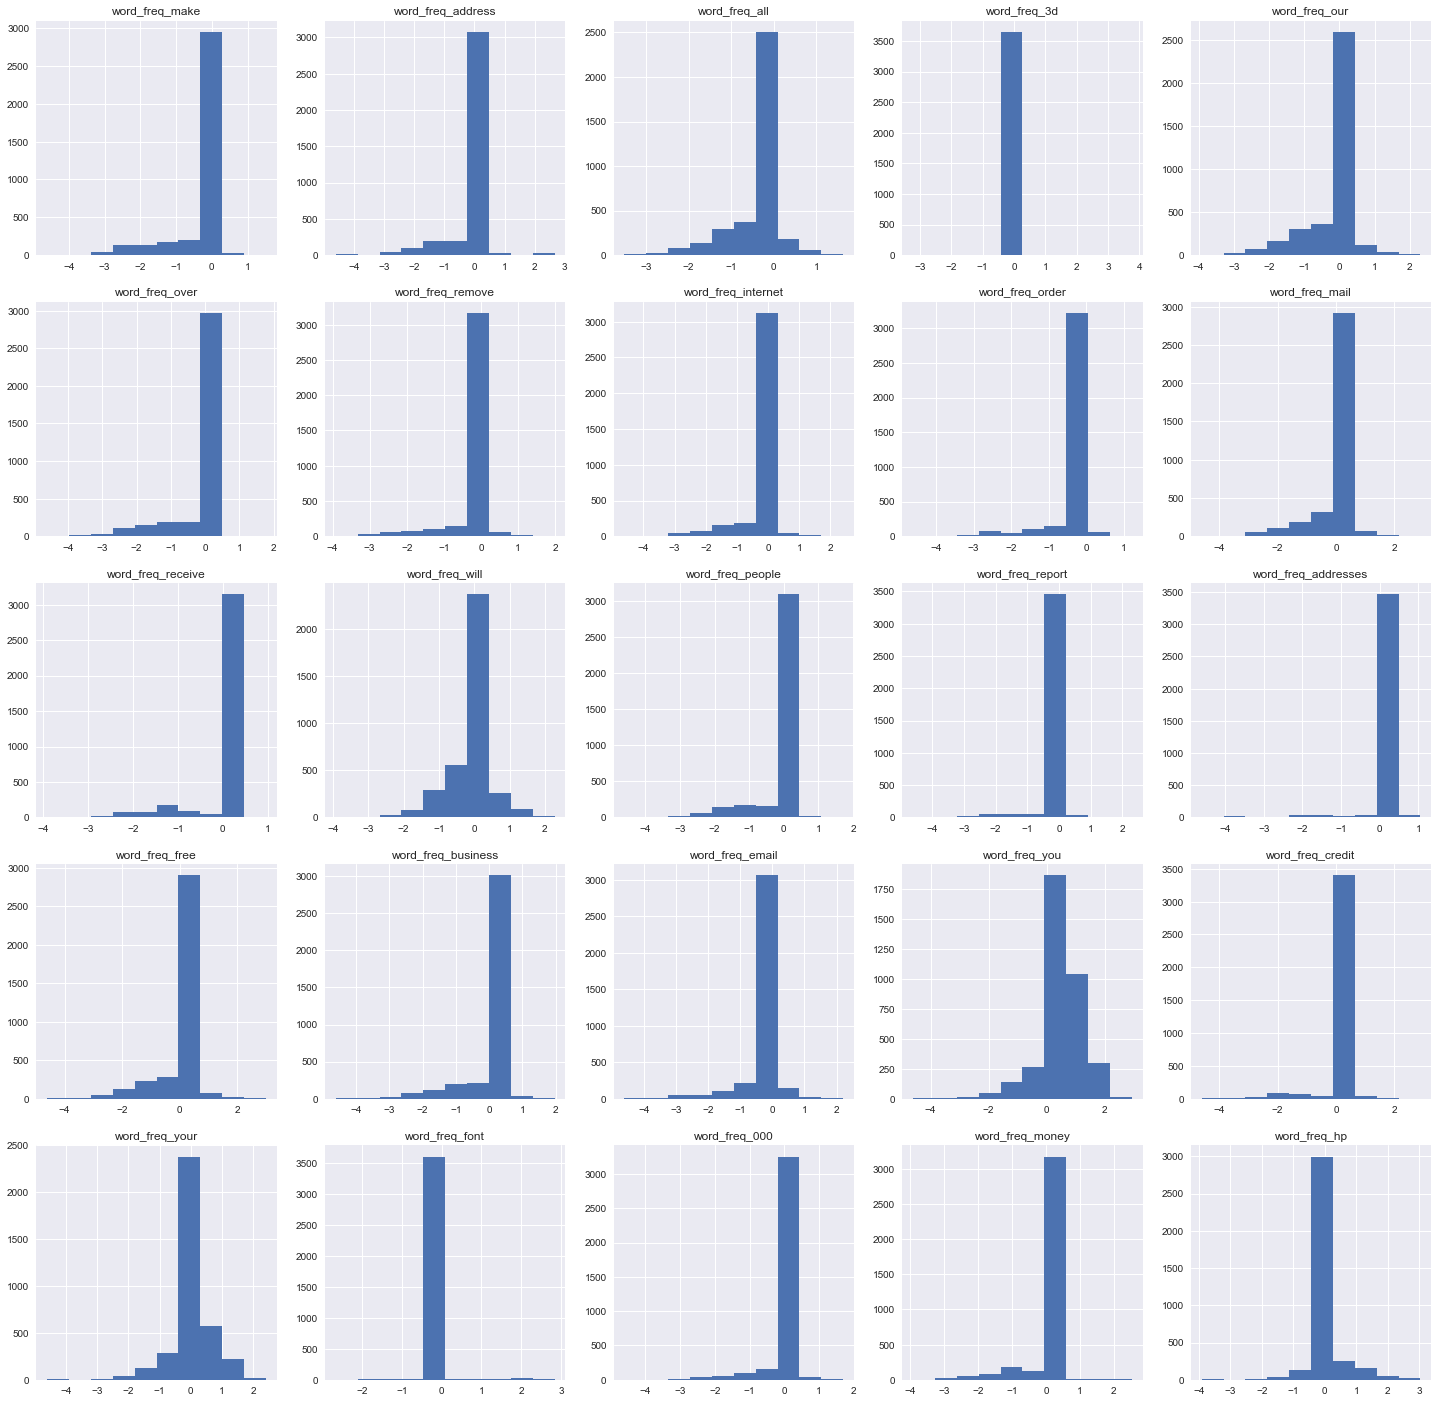

In [116]:
# Increment k for every 25, highest is 32
f, ax = plt.subplots(nrows=5, ncols=5, sharex=False, sharey=False, figsize=(25,25))
k=0
for i in range(0,5):
    for j in range(0,5):
        ax[i,j].set_title(X_train.columns[(i*5+j+k)])
        ax[i,j].hist(X_train.iloc[:, (i*5+j+k)])

In [198]:
# Log all my features
def log_var(x):
    if x==0 or x=="nan": return 0
    else: return np.log(x)

In [199]:
X_train_logged=X_train.copy()
for i in range(len(X_train.columns)):
    X_train_logged[X_train_logged.columns[i]]=[log_var(x) for x in X_train_logged[X_train_logged.columns[i]]]
X_test_logged=X_test.copy()
for i in range(len(X_test.columns)):
    X_test_logged[X_test_logged.columns[i]]=[log_var(x) for x in X_test_logged[X_test_logged.columns[i]]]

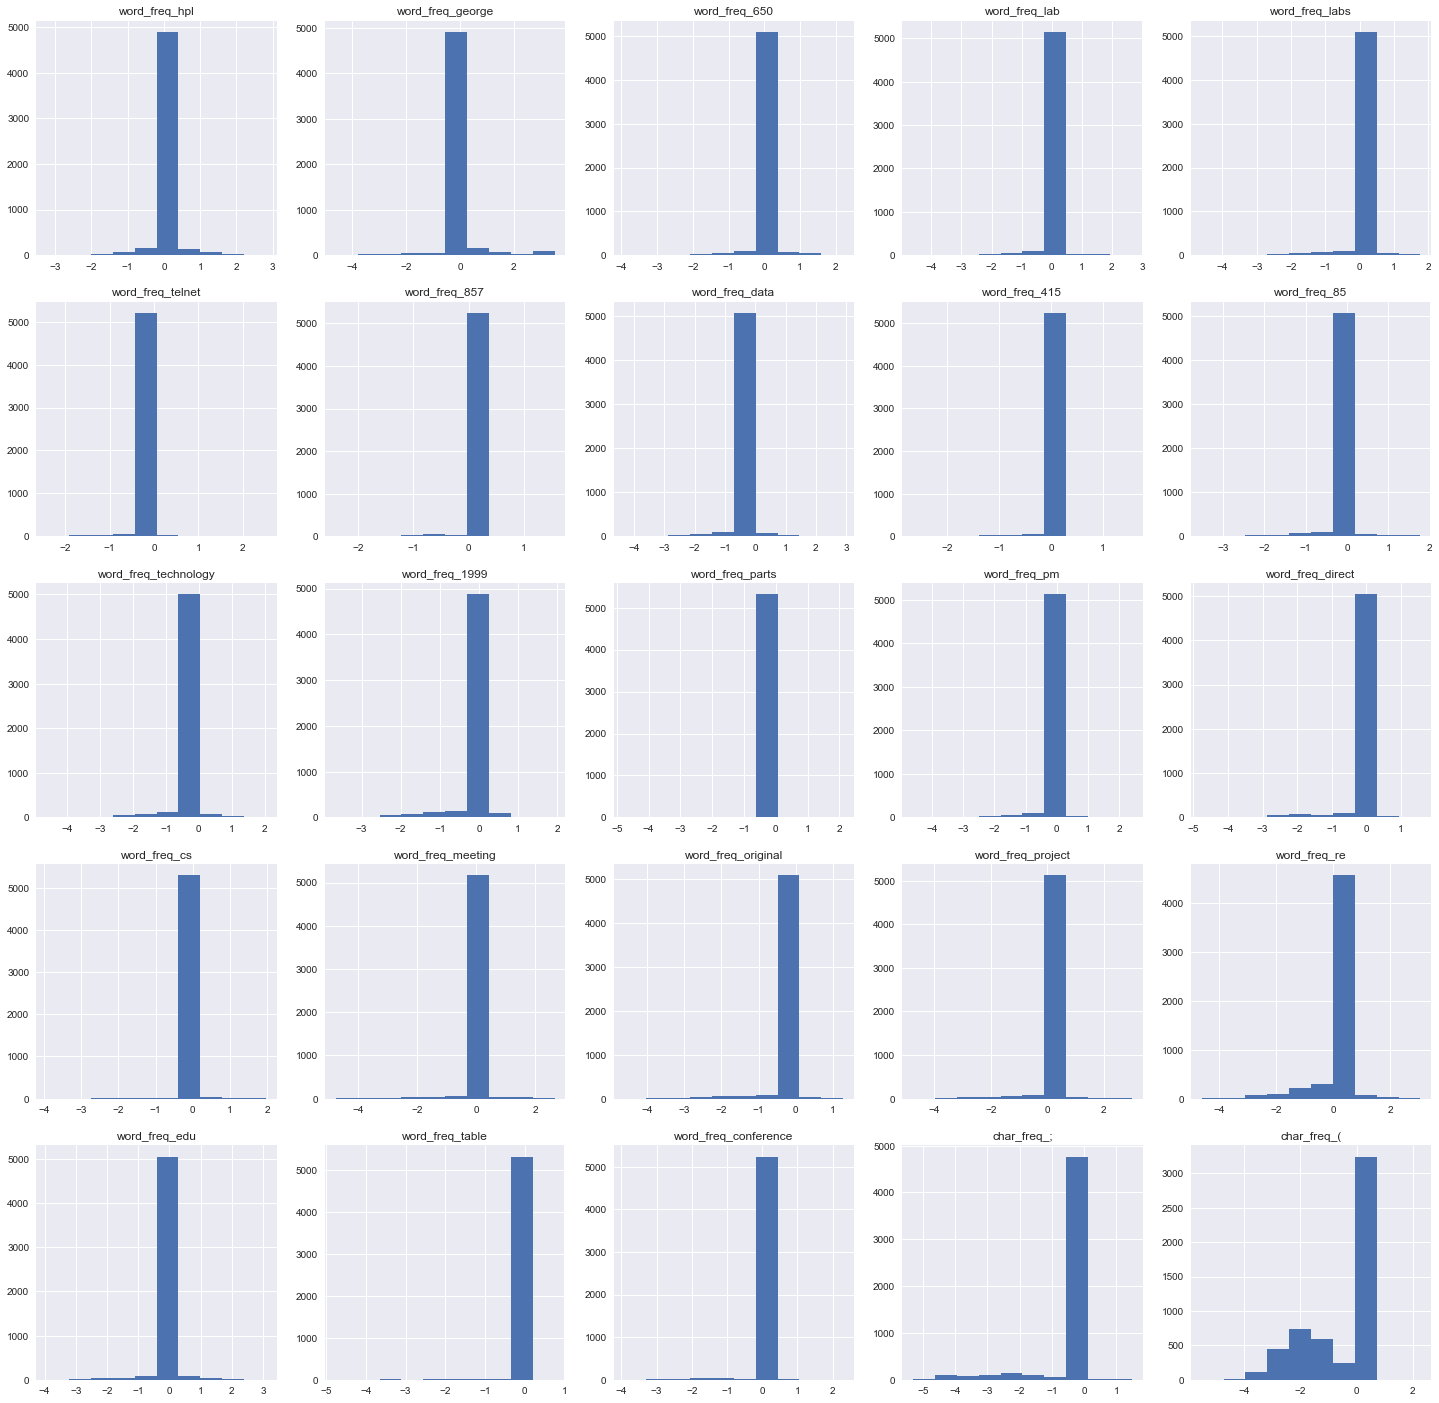

In [201]:
# Increment k for every 25, highest is 32
f, ax = plt.subplots(nrows=5, ncols=5, sharex=False, sharey=False, figsize=(25,25))
k=25
for i in range(0,5):
    for j in range(0,5):
        ax[i,j].set_title(X_train_logged.columns[(i*5+j+k)])
        ax[i,j].hist(X_train_logged.iloc[:, (i*5+j+k)])

In [ ]:
# feat_quant=['Total_Score', 'Altitude', 'Acidity', 'Sweetness',
#        'Moisture', 'Defects_cat1', 'Quakers', 'Defects_cat2', 'total_weight']
# corr2=df[feat_quant].corr()
# sns.pairplot(corr2, diag_kind="kde");

In [202]:
from sklearn.preprocessing import StandardScaler
ssX = StandardScaler()
X_train_scaled=ssX.fit_transform(X_train_logged)
X_test_scaled=ssX.transform(X_test_logged)

__PCA for visualization__

In [120]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X_train_scaled)
pcafeatures_train = pca.transform(X_train_scaled)

In [121]:
pcafeatures_train=pd.DataFrame(pcafeatures_train, columns=['Component1', 'Component2'])
pcafeatures=pd.merge(pcafeatures_train, pd.DataFrame(y_train), left_index=True, right_index=True)
pcafeatures.head()

,Component1,Component2,spam
1,-1.561195,0.269604,1
2,-2.741587,0.081654,1
3,-1.176066,-0.418344,1
4,1.076224,1.195077,1
5,0.402352,-0.636211,1


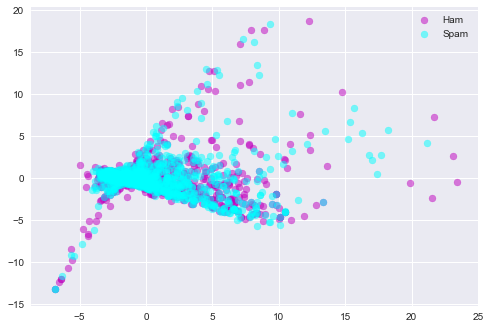

In [122]:
colors = ['m','aqua']
label=['Ham', 'Spam']
plt.figure()
for class_label, color, label in zip([0,1], colors, label):
    plt.scatter(pcafeatures.loc[pcafeatures['spam'] == class_label, 'Component1'],
            pcafeatures.loc[pcafeatures['spam'] == class_label, 'Component2'],
            c=color, label=label, alpha=0.5)
plt.legend()

## Model Testing

In [203]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV

In [177]:
X_train, X_test, y_train, y_test = train_test_split(df_all.iloc[:, :-1], df_all.iloc[:, -1], test_size = 0.2, random_state=42)

In [178]:
# Naive Bayes - Multi using unlogged and unscaled data
NB_Multi= MultinomialNB()
params = {
    'alpha': list(range(0,10)) 
#     'fit_prior': True, 
#     'class_prior': None
}
grid = GridSearchCV(NB_Multi, param_grid=params, cv=10)
grid.fit(X_train, y_train)
print("Train score:", grid.best_score_)
print("Test score:", grid.best_estimator_.score(X_test, y_test))
grid.best_estimator_

Train score: 0.70033358043
Test score: 0.71037037037


MultinomialNB(alpha=0, class_prior=None, fit_prior=True)

In [179]:
# Naive Bayes - Gaussian using logged scaled data
NB_G= GaussianNB()
# params = {'priors': None }
# grid = GridSearchCV(NB_G, param_grid=params, cv=10)
# grid.fit(X_train, y_train)
# print("Train score:", grid.best_score_)
# print("Test score:", grid.best_estimator_.score(X_test, y_test))
# grid.best_estimator_
scores = cross_val_score(NB_G, X_train_scaled, y_train, scoring='accuracy', n_jobs=1)
print("Score (scaled): " + str(np.mean(scores)))
scores = cross_val_score(NB_G, X_train, y_train, scoring='accuracy', n_jobs=1)
print("Score (unscaled): " + str(np.mean(scores)))

Score (scaled): 0.774120627858
Score (unscaled): 0.669014954888


In [185]:
# Naive Bayes - Bernoulli using unlogged and unscaled data
NB_Bern= BernoulliNB()
params = {
    'alpha': list(range(0,10)) ,
    'binarize': list(range(0,50, 10)) 
#     , 
#     'fit_prior': True, 
#     'class_prior': None
}
grid = GridSearchCV(NB_Bern, param_grid=params, cv=10)
grid.fit(X_train, y_train)
print("Train score:", grid.best_score_)
print("Test score:", grid.best_estimator_.score(X_test, y_test))
grid.best_estimator_

Train score: 0.847108969607
Test score: 0.836296296296


BernoulliNB(alpha=0, binarize=0, class_prior=None, fit_prior=True)

In [184]:
# Naive Bayes - Bernoulli using logged but unscaled data
NB_Bern= BernoulliNB()
params = {
    'alpha': list(range(0,10)) ,
    'binarize': list(range(0,50, 10)) 
#     , 
#     'fit_prior': True, 
#     'class_prior': None
}
grid = GridSearchCV(NB_Bern, param_grid=params, cv=10)
grid.fit(X_train_logged, y_train)
print("Train score:", grid.best_score_)
print("Test score:", grid.best_estimator_.score(X_test_logged, y_test))
grid.best_estimator_

Train score: 0.819310600445
Test score: 0.812592592593


BernoulliNB(alpha=1, binarize=0, class_prior=None, fit_prior=True)

In [183]:
# Naive Bayes - Bernoulli using scaled and logged data
NB_Bern= BernoulliNB()
params = {
    'alpha': list(range(0,10)) ,
    'binarize': list(range(0,50, 10)) 
#     , 
#     'fit_prior': True, 
#     'class_prior': None
}
grid = GridSearchCV(NB_Bern, param_grid=params, cv=10)
grid.fit(X_train_scaled, y_train)
print("Train score:", grid.best_score_)
print("Test score:", grid.best_estimator_.score(X_test_scaled, y_test))
grid.best_estimator_

Train score: 0.793365455893
Test score: 0.794814814815


BernoulliNB(alpha=0, binarize=0, class_prior=None, fit_prior=True)

In [187]:
df_all['spam'].value_counts()/sum(df_all['spam'].value_counts())

0    0.641714
1    0.358286
Name: spam, dtype: float64

__SVM__
RBf was the best

In [209]:
from sklearn.svm import LinearSVC

In [211]:
SVM_Linear = LinearSVC()
params = {
        'penalty': ['l1', 'l2']  ,
        'C': np.logspace(-5,8, 10), 
        'dual': [False]
}
grid = GridSearchCV(SVM_Linear, param_grid=params, cv=3)
grid.fit(X_train_scaled, y_train)
print("Train score:", grid.best_score_)
print("Test score:", grid.best_estimator_.score(X_test_scaled, y_test))
grid.best_estimator_

Train score: 0.81671608599
Test score: 0.816296296296


LinearSVC(C=0.21544346900318823, class_weight=None, dual=False,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=None,
     tol=0.0001, verbose=0)

In [212]:
SVM_Linear= LinearSVC()
params = {
        'loss': ['hinge', 'squared_hinge'] ,
        'C': np.logspace(-5,8, 10)
}
grid = GridSearchCV(SVM_Linear, param_grid=params, cv=3)
grid.fit(X_train_scaled, y_train)
print("Train score:", grid.best_score_)
print("Test score:", grid.best_estimator_.score(X_test_scaled, y_test))
grid.best_estimator_

Train score: 0.819310600445
Test score: 0.808888888889


LinearSVC(C=0.21544346900318823, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [192]:
svm= SVC()
params = {
        'kernel': ['rbf'],      
        'C': np.logspace(-5,7, 10),
        'gamma': np.logspace(-5,7, 10)  
}
grid = GridSearchCV(svm, param_grid=params, cv=5)
grid.fit(X_train_scaled, y_train)
print("Train score:", grid.best_score_)
print("Test score:", grid.best_estimator_.score(X_test_scaled, y_test))
grid.best_estimator_

Train score: 0.875833951075
Test score: 0.865185185185


SVC(C=1000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0046415888336127772,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Train score: 0.875833951075  
Test score: 0.865185185185  
SVC(C=1000.0, cache_size=200, class_weight=None, coef0=0.0,  
  decision_function_shape='ovr', degree=3, gamma=0.0046415888336127772,  
  kernel='rbf', max_iter=-1, probability=False, random_state=None,  
  shrinking=True, tol=0.001, verbose=False)

__Tune the RandomForet Model__   
_The best model with scaled data:_  
Train score: 0.8917716827279466  
Test score: 0.8896296296296297  
RandomForestClassifier(bootstrap=True, class_weight=None, __criterion='gini'__,  
            __max_depth=8__, max_features='auto', max_leaf_nodes=None,  
            min_impurity_decrease=0.0, min_impurity_split=None,  
            __min_samples_leaf=1__, min_samples_split=2,  
            min_weight_fraction_leaf=0.0, __n_estimators=350__, n_jobs=1,  
            oob_score=False, random_state=None, verbose=0,  
            warm_start=False)

In [ ]:
# Random Forest with scaled data: Train score: 0.8726834692364714, Test score: 0.857037037037037
# Now try RF with unscaled data:
# This is the one I am pickling
rf = RandomForestClassifier()
params = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': list(range(200,500,50)),
    'max_depth': list(range(13,20)),
    'min_samples_leaf': list(range(1,6,2)),
}
grid = GridSearchCV(rf, param_grid=params, cv=5, scoring='precision')
grid.fit(X_train, y_train)
print("Train score:", grid.best_score_)
print("Test score:", grid.best_estimator_.score(X_test, y_test))
grid.best_estimator_

_with unscaled data and only up to max_depth 20_  
Train score: 0.94514455152  
Test score: 0.944444444444  
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',  
            max_depth=19, max_features='auto', max_leaf_nodes=None,  
            min_impurity_decrease=0.0, min_impurity_split=None,  
            min_samples_leaf=1, min_samples_split=2,  
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,  
            oob_score=False, random_state=None, verbose=0,  
            warm_start=False)  
              
_with unscaled data and only up to max_depth 12_  
Train score: 0.926797627872  
Test score: 0.925925925926  
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',  
            max_depth=12, max_features='auto', max_leaf_nodes=None,  
            min_impurity_decrease=0.0, min_impurity_split=None,  
            min_samples_leaf=1, min_samples_split=2,  
            min_weight_fraction_leaf=0.0, n_estimators=350, n_jobs=1,  
            oob_score=False, random_state=None, verbose=0,  
            warm_start=False)

In [ ]:
pickle.dump(grid, open('RF_unscaled_unlogged_grid.pkl', 'wb'))

In [261]:
model_all=pickle.load(open('RF_unscaled_unlogged_grid.pkl', 'rb'))

In [262]:
print("Train - all combine data, RF model with unscaled unlogged data")
pred_train = model_all.predict(X_train)
Eval(y_train, pred_train)
print()
print("Test - all combine data, RF model with unscaled unlogged data")
pred_test=model_all.predict(X_test)
Eval(y_test, pred_test)

Train - all combine data, RF model with unscaled unlogged data
Accuracy:  98.91%
Precision:  99.89%
Recall:  97.00%
ROC AUC:  98.47%
False Negative Rate: 1.61%
False Positve Rate:  0.11%

Test - all combine data, RF model with unscaled unlogged data
Accuracy:  94.44%
Precision:  94.89%
Recall:  90.27%
ROC AUC:  93.64%
False Negative Rate: 5.81%
False Positve Rate:  5.11%


,Pred NOT Spam,Pred Spam
Actual NOT Spam,811,25
Actual Spam,50,464


In [260]:
print("Train Reort - DF_all")
print(classification_report(y_train, preds))
print("Test Reort - DF_all")
print(classification_report(y_test, preds_test))

Train Reort - DF_all
             precision    recall  f1-score   support

          0       0.98      1.00      0.99      3493
          1       1.00      0.97      0.98      1903

avg / total       0.99      0.99      0.99      5396

Test Reort - DF_all
             precision    recall  f1-score   support

          0       0.94      0.97      0.96       836
          1       0.95      0.90      0.93       514

avg / total       0.94      0.94      0.94      1350



ROC AUC score =  0.978570131998


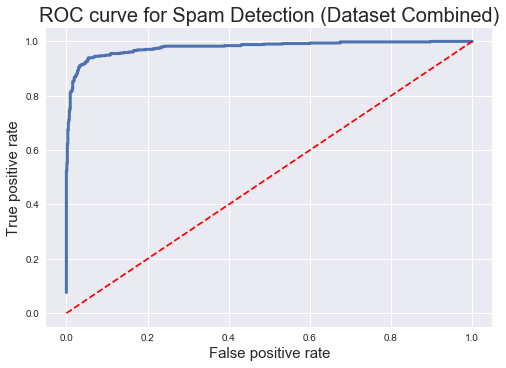

In [265]:
fpr, tpr, thresholds = roc_curve(y_test, model_all.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr,lw=3)
plt.plot([0,1],[0,1],c='r',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate', fontsize=15)
plt.ylabel('True positive rate', fontsize=15)
plt.title('ROC curve for Spam Detection (Dataset Combined)', fontsize=20);
print("ROC AUC score = ", roc_auc_score(y_test, model_all.predict_proba(X_test)[:,1]))

In [269]:
def make_confusion_matrix(model, X, y, threshold=0.5, dpi=80):
    import seaborn as sns
    y_predict = (model.predict_proba(X)[:, 1] >= threshold)
    confusion = confusion_matrix(y, y_predict)
    plt.figure(dpi=dpi)
    sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d', annot_kws={"size": 20},
           xticklabels=['Legit', 'Spam'],
           yticklabels=['Legit', 'Spam']);
    plt.xlabel('Prediction', fontsize=15)
    plt.ylabel('Actual', fontsize=15)

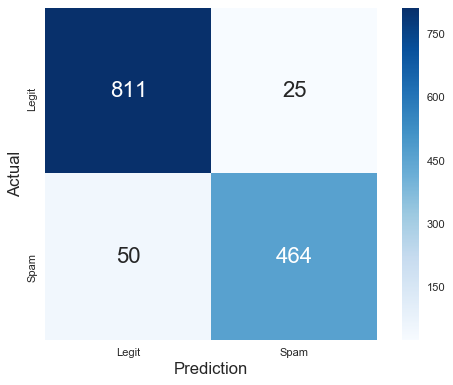

In [270]:
make_confusion_matrix(model_all, X_test, y_test)